# CIFAR10 Autoencoder

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from sklearn.model_selection import train_test_split

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import TensorDataset,DataLoader,Subset

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download + load training set
train = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=transform
)

# Download + load test set
dev = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=transform
)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


In [4]:
# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(train,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(dev,  batch_size=len(dev))

In [5]:
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 32, 32])

Data value range:
(tensor(-1.), tensor(1.))


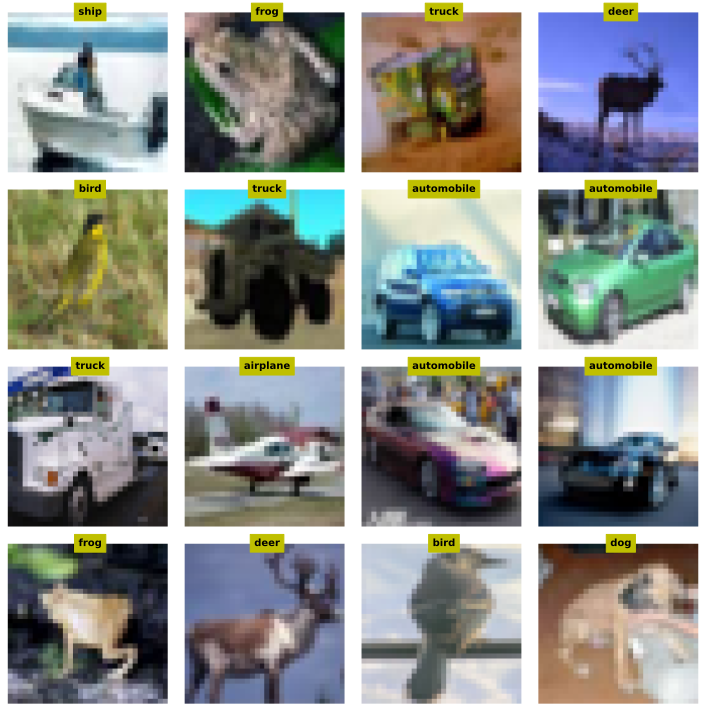

In [6]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = train.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# create a class for the model
def makeTheNet():

  class Cifarnet(nn.Module):
    def __init__(self):
      super().__init__()

      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(3,16,4,stride=2,padding=1),
          nn.ReLU(),
          nn.Conv2d(16,32,4,stride=2,padding=1),
          nn.ReLU(),
          nn.Conv2d(32,64,4,stride=2,padding=1),
          nn.ReLU(),
          )

      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(64,32,4,stride=2,padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(16,3,4,stride=2,padding=1),
          )

    def forward(self,x):
      return self.dec( self.enc(x) )

  # create the model instance
  net = Cifarnet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [8]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
torch.Size([32, 3, 32, 32])
torch.Size([32])
 
Loss:
tensor(27.3397, grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [9]:
print(y.shape)

torch.Size([32])


In [10]:
import time

# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  net.to(device)

  # initialize losses
  trainLosses    = torch.zeros(numepochs)
  devLosses    = torch.zeros(numepochs)


  start_time = time.time()


  # loop over epochs
  for epochi in range(numepochs):
    print("Start of Epoch", epochi, "at", round(time.time() - start_time, 2), "seconds")
    # loop over training data batches
    net.train()
    batchLoss = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)

      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())


    # and get average losses across the batches
    trainLosses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)


    lossdev = lossfun(yHat,X)

    devLosses[epochi] = lossdev.item()


  # end epochs

  # function output
  return trainLosses,devLosses,net

In [11]:
trainLosses,devLosses,net = function2trainTheModel()

Start of Epoch 0 at 0.0 seconds
Start of Epoch 1 at 19.6 seconds
Start of Epoch 2 at 37.86 seconds
Start of Epoch 3 at 56.03 seconds
Start of Epoch 4 at 73.25 seconds
Start of Epoch 5 at 91.09 seconds
Start of Epoch 6 at 108.57 seconds
Start of Epoch 7 at 125.74 seconds
Start of Epoch 8 at 143.6 seconds
Start of Epoch 9 at 160.69 seconds


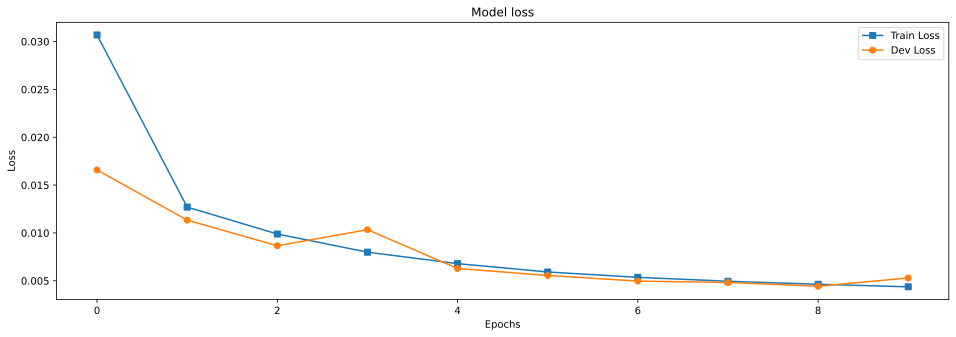

In [14]:
fig,ax = plt.subplots(1,1,figsize=(16,5))

ax.plot(trainLosses, 's-', label='Train Loss')
ax.plot(devLosses, 'o-', label='Dev Loss')
#ax.plot(len(devLosses)-1,lossTest,'r*',markersize=15,label='Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Model loss')
ax.legend()

In [15]:
net.eval()
X,y = next(iter(dev_loader)) # extract X,y from test dataloader

# push data to GPU
X = X.to(device)
y = y.to(device)

with torch.no_grad(): # deactivates autograd
  yHat = net(X)

In [17]:
print(X.shape)
print(yHat.shape)

torch.Size([10000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


In [20]:
X = X.cpu()
yHat = yHat.cpu()

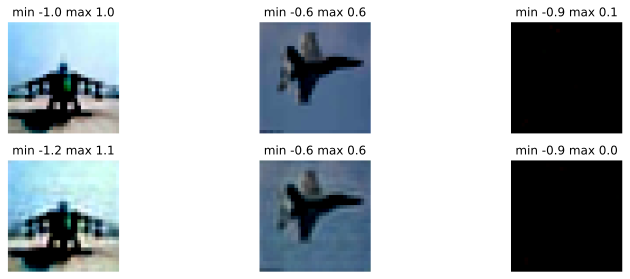

In [30]:
import torch
import matplotlib.pyplot as plt
import random

# Suppose this is your dataset tensor
#images = torch.randn(10000, 3, 32, 32)  # Replace with your actual tensor

# Pick 3 random indices
indices = random.sample(range(X.shape[0]), 3)

fig, axes = plt.subplots(2, 3, figsize=(12, 4))

for i, idx in enumerate(indices):
    img = X[idx]
    img2 = yHat[idx]
    # Convert from CxHxW to HxWxC for matplotlib
    img = img.permute(1, 2, 0)
    img2 = img2.permute(1, 2, 0)
    # If your images are not in [0,1], normalize for display
    #img = (img - img.min()) / (img.max() - img.min())
    #img2 = (img2 - img2.min()) / (img2.max() - img2.min())

    axes[0,i].imshow(img)
    axes[0,i].axis('off')
    axes[0, i].set_title(f'min {img.min():.1f} max {img.max():.1f}')

    axes[1,i].imshow(img2)
    axes[1,i].axis('off')
    axes[1, i].set_title(f'min {img2.min():.1f} max {img2.max():.1f}')

plt.tight_layout()
plt.show()